In [21]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import perf_counter

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *

## NumPy simulation

In [22]:
def run_numpy_simulation(gate_fidelity, epr_channel_fidelity):
    # Define U_A, U_B unitaries
    U_A = Rot_X(np.pi / 2)
    U_B = Rot_X(- np.pi / 2)

    # Define target state as the Bell state |phi_{00}>
    TARGET_STATE = bell_state()

    # Create DEJMPS circuit
     # NOTE: we apply depolarizing channels only to 
    # gates that appear in the original DEJMPS protocol,
    # and not to additional SWAP gates
    dejmps_circuit = QuantumCircuit([
        Gate(kron([U_A, I(), I(), I()])),   # Apply U_A, U_B gates on each EPR pair
        DepolarizingChannel(gate_fidelity, 4, [0]),
        Gate(kron([I(), U_B, I(), I()])),   # Apply U_A, U_B gates on each EPR pair
        DepolarizingChannel(gate_fidelity, 4, [1]),
        Gate(kron([I(), I(), U_A, I()])),   # Apply U_A, U_B gates on each EPR pair
        DepolarizingChannel(gate_fidelity, 4, [2]),
        Gate(kron([I(), I(), I(), U_B])),   # Apply U_A, U_B gates on each EPR pair
        DepolarizingChannel(gate_fidelity, 4, [3]),

        Gate(kron([I(), SWAP(), I()])),     # Swap qubits 1B, 2A (arange qubits in order: |1A, 2A, 1B, 2B>)

        Gate(kron([CNOT(), I(), I()])),     # Apply CNOT(1A, 2A) and CNOT(1B, 2B)
        DepolarizingChannel(gate_fidelity, 4, [0, 1]),
        Gate(kron([I(), I(), CNOT()])),     # Apply CNOT(1A, 2A) and CNOT(1B, 2B)
        DepolarizingChannel(gate_fidelity, 4, [2, 3]),

        Gate(kron([I(), SWAP(), I()])),     # Swap back qubits 2A, 1B (rearange qubits in order: |1A, 1B, 2A, 2B>)
        # Measure qubits {2A, 2B}:
        POVM(num_qubits=4, meas_qubits=[2, 3], partial_trace=True),
    ])

    # Create two EPR pairs between Alice and Bob
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Create ensemble of two EPR pairs (qubits in order: |1A, 1B, 2A, 2B>)
    rho = kron([epr_1, epr_2])

    # Apply DEJMPS circuit
    probs, rho_outs = dejmps_circuit(rho)

    # Compute fidelity wrt. the Bell state phi_00
    fidels = np.array([fidelity(dm, TARGET_STATE) for dm in rho_outs])

    # Compute probability of success and average fidelity **given** success
    prob_succ = np.sum(probs[[0, 3]])
    fidel_succ = np.dot(fidels[[0, 3]], probs[[0, 3]]) / prob_succ

    return prob_succ, fidel_succ

In [23]:
GRID_SIZE = 11
numpy_sim_results = []

for gate_fidelity in np.linspace(0, 1, GRID_SIZE):
    for epr_channel_fidelity in np.linspace(0, 1, GRID_SIZE):
        prob_succ, fidel_succ = run_numpy_simulation(gate_fidelity, epr_channel_fidelity)
        numpy_sim_results.append([gate_fidelity, epr_channel_fidelity, prob_succ, fidel_succ])

numpy_sim_results = np.array(numpy_sim_results)

cols = ['Gate fidelity', 'EPR channel fidelity', 'P_Succ', 'F_succ']
numpy_sim_results = pd.DataFrame(numpy_sim_results, columns=cols)

numpy_sim_results

,Gate fidelity,EPR channel fidelity,P_Succ,F_succ
0,0.0,0.0,0.500,0.250000
1,0.0,0.1,0.500,0.250000
2,0.0,0.2,0.500,0.250000
3,0.0,0.3,0.500,0.250000
4,0.0,0.4,0.500,0.250000
...,...,...,...,...
116,1.0,0.6,0.680,0.735294
117,1.0,0.7,0.745,0.813758
118,1.0,0.8,0.820,0.884146
119,1.0,0.9,0.905,0.946133


## Extracting results from NetQASM simulation 

In [24]:
def _get_p_succ_and_f_succ(df: pd.DataFrame):
    """Computes the probability of success and fidelity given success."""
    return [
        1 - (df['M_Alice'] ^ df['M_Bob']).mean(),
        df.query('M_Alice == M_Bob')['Fidelity'].mean(),
    ]


def _series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concat(row) for row in s.items()])


def get_p_succ_and_f_succ(data: pd.DataFrame):
    """
    Computes the probability of success and fidelity given success, 
    grouped by gate and EPR channel fidelities, in the given `DataFrame`.
    """
    # Group data by gate and channel fidelity
    result = data.groupby(['Gate fidelity', 'EPR channel fidelity'])

    result = result.apply(_get_p_succ_and_f_succ, include_groups=False)
    result = _series_to_numpy(result)

    cols = ['Gate fidelity', 'EPR channel fidelity', 'P_succ', 'F_succ']
    result = pd.DataFrame(result, columns=cols)

    return result

# Read simulation results
netqasm_sim_results = pd.read_csv('./dejmps.out.csv')
netqasm_sim_results = get_p_succ_and_f_succ(netqasm_sim_results)

netqasm_sim_results

,Gate fidelity,EPR channel fidelity,P_succ,F_succ
0,0.0,1.0,0.474,0.299578
1,0.2,1.0,0.504,0.265873
2,0.4,1.0,0.510,0.270588
3,0.6,1.0,0.518,0.335907
4,0.8,1.0,0.604,0.493377
5,1.0,0.0,0.490,0.230612
6,1.0,0.2,0.520,0.363462
7,1.0,0.4,0.560,0.551687
8,1.0,0.6,0.674,0.761226
9,1.0,0.8,0.838,0.856802


## Plotting results of simulations

In [25]:
def prob_succ_theory(epr_channel_fidelity: float):
    """Computes the DEJMPS probability of success using the theoretical formula."""
    return (1 + epr_channel_fidelity ** 2) / 2


def fidelity_succ_theory(epr_channel_fidelity: float, niters: int=0):
    """Computes DEJMPS fidelity given protocol success using the theoretical formula."""
    dm = werner_state(epr_channel_fidelity)
    A = fidelity(dm, bell_state(0, 0))
    B = fidelity(dm, bell_state(1, 1))
    C = fidelity(dm, bell_state(1, 0))
    D = fidelity(dm, bell_state(0, 1))

    for _ in range(niters):
        N = (A + B) ** 2 + (C + D) ** 2
        A = (A ** 2 + B ** 2) / N
        B = (2 * C * D) / N
        C = (C ** 2 + D ** 2) / N
        D = (2 * A * B) / N

    return A

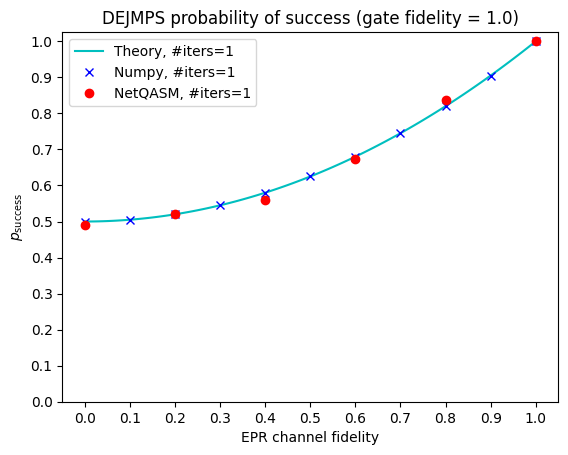

In [26]:
ps = np.linspace(0, 1, 101)
plt.plot(
    ps, prob_succ_theory(ps),
    'c-', label='Theory, #iters=1',
)
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'], 
    numpy_sim_results.query('`Gate fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('DEJMPS probability of success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

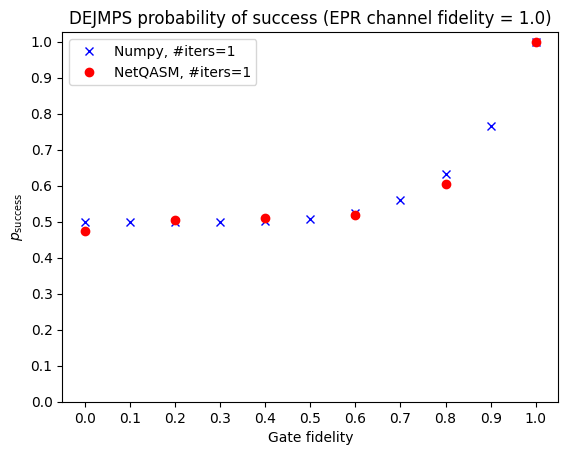

In [27]:
ps = np.linspace(0, 1, 101)
plt.plot(
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'], 
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'],
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('DEJMPS probability of success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

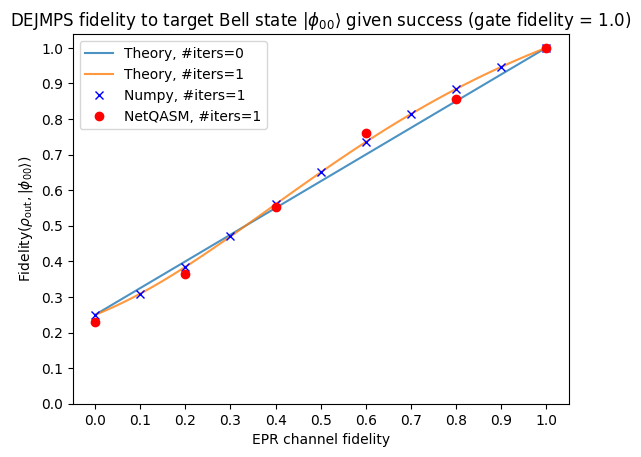

In [28]:
ps = np.linspace(0, 1, 101)

for niters in range(0, 2):
    foo = np.vectorize(lambda p: fidelity_succ_theory(p, niters))
    plt.plot(
        ps, foo(ps), 
        alpha=0.8,
        label=f'Theory, #iters={niters}',
    )

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'], 
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'], 
    'xb', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'DEJMPS fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

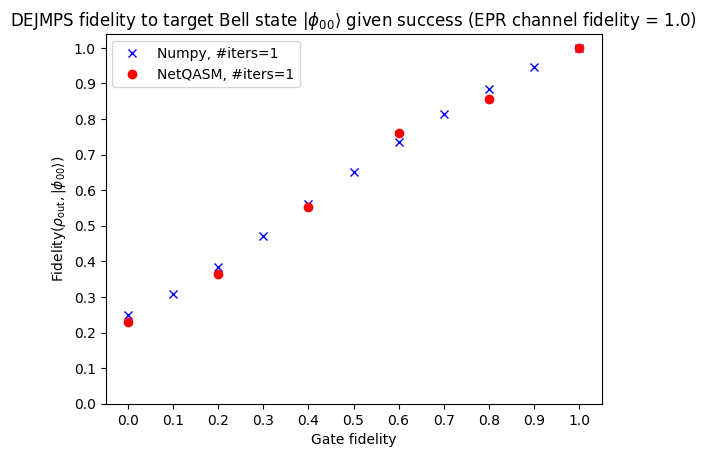

In [29]:
ps = np.linspace(0, 1, 101)

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'], 
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'], 
    'xb', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'DEJMPS fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

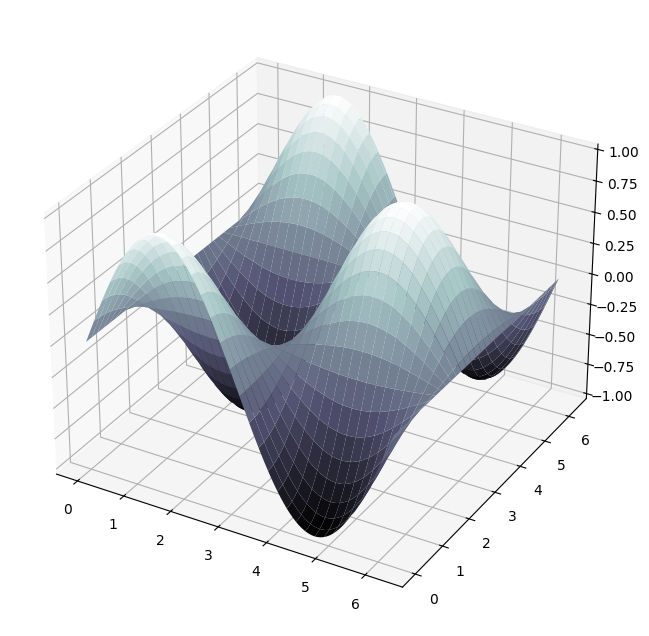

In [30]:
# Example of 3D plot

ax = plt.figure(figsize=(8, 8)) \
        .add_subplot(projection='3d')

x, y = np.meshgrid(np.linspace(0, 2 * np.pi, 101), np.linspace(0, 2 * np.pi, 101))
ax.plot_surface(
    x, y, 
    np.sin(x) * np.cos(y),
    cmap='bone',
    alpha=1.0,
)
ax.view_init(azim=-60, elev=30)
plt.show()

In [31]:
# data = pd.read_csv('./out.csv')
# data = data.sort_values('EPR channel fidelity')
# data = data.query('`Gate fidelity` == 1.0 or `EPR channel fidelity` == 1.0')
# data = data[['Gate fidelity', 'EPR channel fidelity', 'Sample index', 'M_Alice', 'M_Bob', 'Fidelity']]

# n = [-1]
# def foo(_):
#     n[0] += 1
#     return n[0]

# data = data.rename(index=foo)

# data['Sample index'] = np.arange(len(data)) % 500

# data.to_csv('./dejmps.out.csv', mode='w')
# data